In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy

import numpy as np
from scipy import ndimage

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import download_file, clear_download_cache

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors

In [2]:
from caterpillar import catalog

In [3]:
pdr2_zp = 31.4

### COSMOS Dwarf Catalog

In [4]:
merian_dir = '/Users/song/Downloads/merian/'

cosmos_cat = Table.read(os.path.join(merian_dir, 'cosmos', 'COSMOS_dwarfs_Merian.fits'))

print(len(cosmos_cat))
print(cosmos_cat.colnames)

227
['ALPHA_J2000', 'DELTA_J2000', 'z_cosmos', 'mass_cosmos']


### HSC PDR2-Wide COSMOS catalog

In [6]:
pdr2_cat = os.path.join(merian_dir, 'cosmos', 'pdr2_cosmos_wide_broad_cut.fits')
pdr2_cos = Table.read(pdr2_cat)

print(len(pdr2_cos))

48133


#### Filter through bright star mask

In [20]:
mask_dir = '/Users/song/astro1/hsc/bright_star_new/'

pdr2_cos_bsm = catalog.filter_through_bright_star_mask(pdr2_cat, mask_dir)


In [8]:
pdr2_cos_bsm = Table.read(os.path.join(merian_dir, 'cosmos', 'pdr2_cosmos_wide_broad_cut_bsm.fits'))

len(pdr2_cos_bsm)

32956

In [13]:
pdr2_cos_bsm = catalog.moments_to_shape(pdr2_cos_bsm, shape_type='i_sdss_shape', update=True)
pdr2_cos_bsm = catalog.moments_to_shape(pdr2_cos_bsm, shape_type='i_cmodel_exp_ellipse', update=True)
pdr2_cos_bsm = catalog.moments_to_shape(pdr2_cos_bsm, shape_type='i_cmodel_ellipse', update=True)
pdr2_cos_bsm = catalog.moments_to_shape(pdr2_cos_bsm, shape_type='r_cmodel_exp_ellipse', update=True)
pdr2_cos_bsm = catalog.moments_to_shape(pdr2_cos_bsm, shape_type='r_cmodel_ellipse', update=True)

#### Get the objects within the bright star masks

In [17]:
mask_dir = '/Users/song/astro1/hsc/bright_star_new/'

pdr2_cos_msk = catalog.filter_through_bright_star_mask(
    pdr2_cat, mask_dir, filter_type='inside', output_suffix='masked')

In [19]:
print(len(pdr2_cos_msk))

pdr2_cos_msk = catalog.moments_to_shape(pdr2_cos_msk, shape_type='i_sdss_shape', update=True)
pdr2_cos_msk = catalog.moments_to_shape(pdr2_cos_msk, shape_type='i_cmodel_exp_ellipse', update=True)
pdr2_cos_msk = catalog.moments_to_shape(pdr2_cos_msk, shape_type='i_cmodel_ellipse', update=True)
pdr2_cos_msk = catalog.moments_to_shape(pdr2_cos_msk, shape_type='r_cmodel_exp_ellipse', update=True)
pdr2_cos_msk = catalog.moments_to_shape(pdr2_cos_msk, shape_type='r_cmodel_ellipse', update=True)

12547


### Matched dwarfs

In [22]:
pdr2_match_cat = os.path.join(merian_dir, 'cosmos', 'pdr2_cosmos_dwarf_match_5arcsec.fits')
pdr2_match_bsm = catalog.filter_through_bright_star_mask(pdr2_match_cat, mask_dir)

print(len(pdr2_match_bsm))

180


In [10]:
pdr2_match_bsm = Table.read(os.path.join(merian_dir, 'cosmos', 'pdr2_cosmos_dwarf_match_5arcsec_bsm.fits'))

In [14]:
pdr2_match_bsm = catalog.moments_to_shape(pdr2_match_bsm, shape_type='i_sdss_shape', update=True)
pdr2_match_bsm = catalog.moments_to_shape(pdr2_match_bsm, shape_type='i_cmodel_exp_ellipse', update=True)
pdr2_match_bsm = catalog.moments_to_shape(pdr2_match_bsm, shape_type='i_cmodel_ellipse', update=True)
pdr2_match_bsm = catalog.moments_to_shape(pdr2_match_bsm, shape_type='r_cmodel_exp_ellipse', update=True)
pdr2_match_bsm = catalog.moments_to_shape(pdr2_match_bsm, shape_type='r_cmodel_ellipse', update=True)

#### Spatial distributions of objects

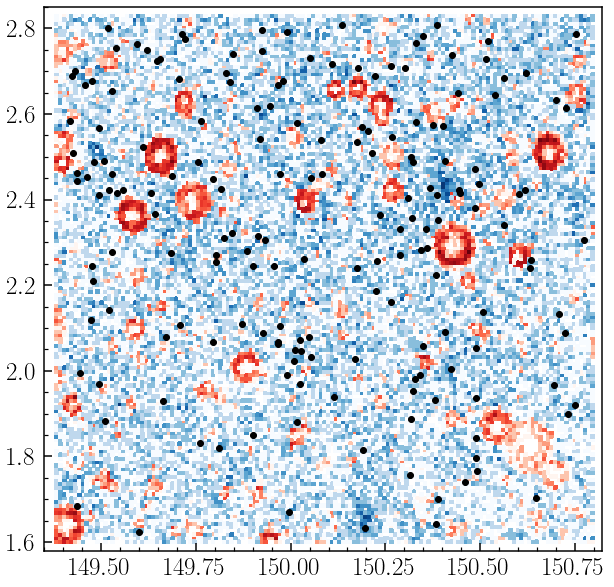

In [12]:
plt.figure(figsize=(10, 10))

_ = plt.hist2d(pdr2_cos['ra'], pdr2_cos['dec'], bins=(150, 150), norm=mpl.colors.LogNorm(),
               range=[[149.35, 150.82], [1.58, 2.85]], cmap='Reds', edgecolor='none')

_ = plt.hist2d(pdr2_cos_bsm['ra'], pdr2_cos_bsm['dec'], bins=(150, 150), alpha=1.0, norm=mpl.colors.LogNorm(),
               range=[[149.35, 150.82], [1.58, 2.85]], cmap='Blues', edgecolor='none')

plt.scatter(pdr2_match_bsm['ra'], pdr2_match_bsm['dec'], c='k')

### Distribution of color and size

<ipython-input-105-60fd7f149426>:44: RuntimeWarning: invalid value encountered in log10
  (-2.5 * np.log10(pdr2_cos_bsm['r_undeblended_convolvedflux_2_15_flux']) + 31.4),


Text(0, 0.5, '$\\log\\ (R_{\\rm CMod,\\ Exp,\\ i}/[\\rm arcsec])$')

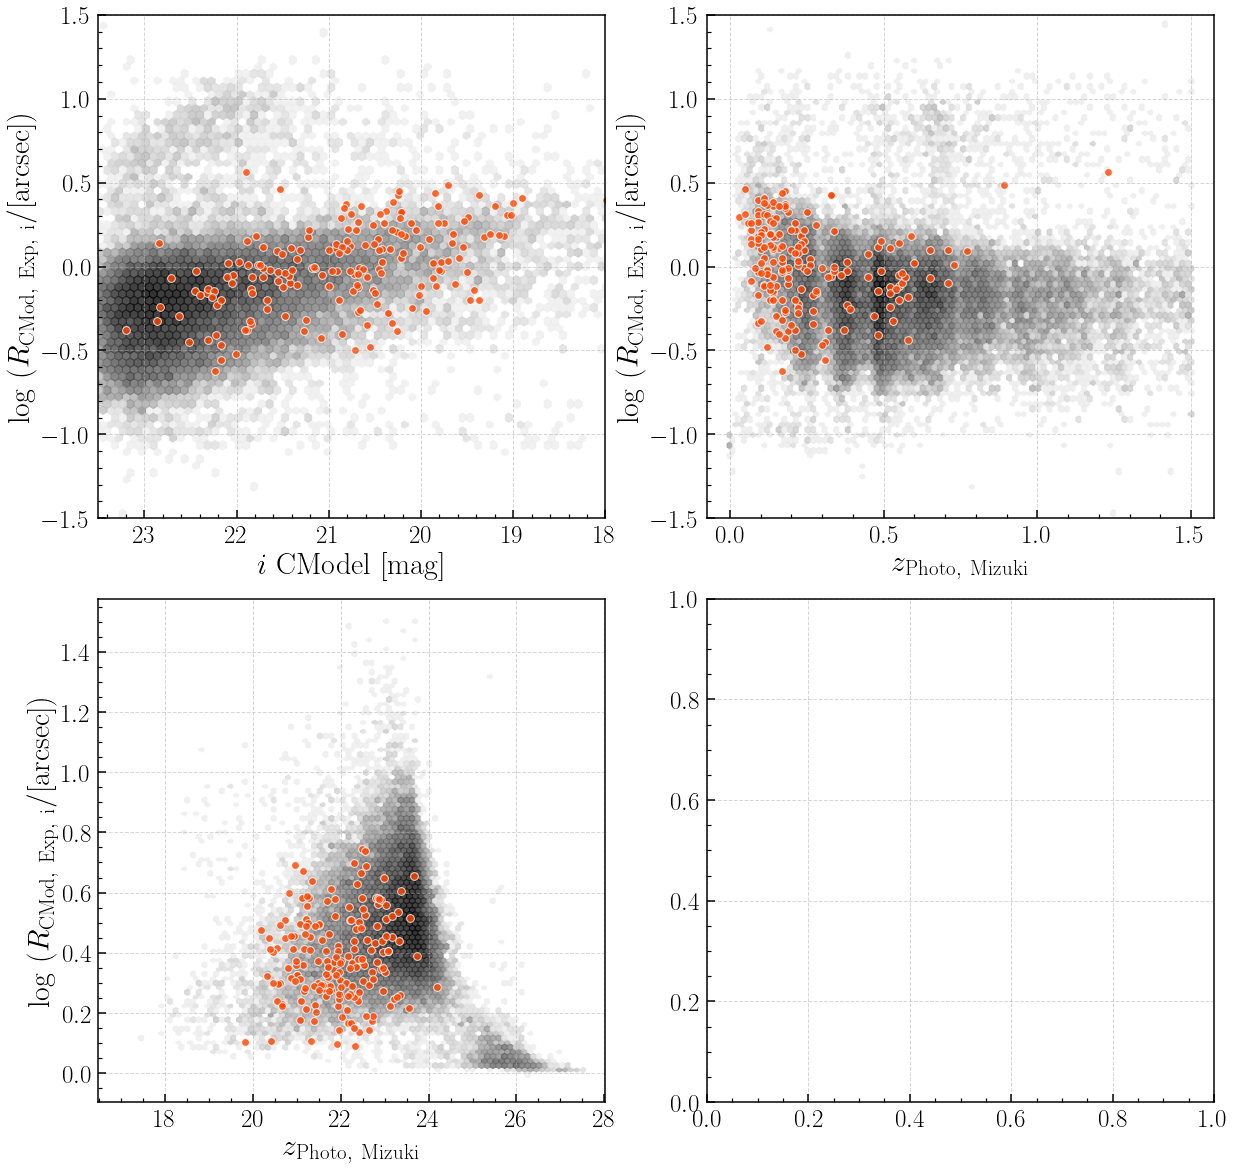

In [105]:
fig, axs = plt.subplots(2, 2, figsize=(20, 20))
plt.subplots_adjust(hspace=0.16)

# Magnitude-Size
ax1 = axs[0, 0]

_ = ax1.hexbin(
    pdr2_cos_bsm['i_cmodel_mag'], np.log10(pdr2_cos_bsm['i_cmodel_exp_ellipse_r']), 
    extent=(17.5, 24.2, -2.5, 1.6), cmap='Greys', bins='log', gridsize=(80, 50),
    alpha=0.8)

_ = ax1.scatter(
    pdr2_match_bsm['i_cmodel_mag'], np.log10(pdr2_match_bsm['i_cmodel_exp_ellipse_r']),
    s=60, alpha=0.8, facecolor='orangered', edgecolor='w')

ax1.set_xlim(23.5, 18.0)
ax1.set_ylim(-1.5, 1.5)

ax1.set_xlabel(r'$i\ \rm CModel\ [mag]$', fontsize=30)
ax1.set_ylabel(r'$\log\ (R_{\rm CMod,\ Exp,\ i}/[\rm arcsec])$', fontsize=30)

# Photo-z-Size
ax2 = axs[0, 1]

_ = ax2.hexbin(
    pdr2_cos_bsm['photoz_best'], np.log10(pdr2_cos_bsm['i_cmodel_exp_ellipse_r']), 
    extent=(0, 1.5, -1.5, 1.6), cmap='Greys', bins='log', gridsize=(80, 50),
    alpha=0.8)

_ = ax2.scatter(
    pdr2_match_bsm['photoz_best'], np.log10(pdr2_match_bsm['i_cmodel_exp_ellipse_r']),
    s=60, alpha=0.8, facecolor='orangered', edgecolor='w')

#ax2.set_xlim(23.5, 18.0)
ax2.set_ylim(-1.5, 1.5)

ax2.set_xlabel(r'$z_{\rm Photo,\ Mizuki}$', fontsize=30)
ax2.set_ylabel(r'$\log\ (R_{\rm CMod,\ Exp,\ i}/[\rm arcsec])$', fontsize=30)

# Photo-z-Size
ax3 = axs[1, 0]

_ = ax3.hexbin(
    (-2.5 * np.log10(pdr2_cos_bsm['r_undeblended_convolvedflux_2_15_flux']) + 31.4), 
    (pdr2_cos_bsm['r_undeblended_convolvedflux_2_15_flux'] / pdr2_cos_bsm['i_cmodel_flux']), 
    extent=(17.0, 27.5, -0.02, 1.5), cmap='Greys', bins='log', gridsize=(80, 50), alpha=0.8)

_ = ax3.scatter(
    (-2.5 * np.log10(pdr2_match_bsm['r_undeblended_convolvedflux_2_15_flux']) + 31.4), 
    (pdr2_match_bsm['r_undeblended_convolvedflux_2_15_flux'] / pdr2_match_bsm['i_cmodel_flux']), 
    s=60, alpha=0.8, facecolor='orangered', edgecolor='w')

#ax3.set_xlim(23.5, 18.0)
#ax3.set_ylim(-1.5, 1.5)

ax3.set_xlabel(r'$z_{\rm Photo,\ Mizuki}$', fontsize=30)
ax3.set_ylabel(r'$\log\ (R_{\rm CMod,\ Exp,\ i}/[\rm arcsec])$', fontsize=30)

<ipython-input-119-a9d92c88e08f>:3: RuntimeWarning: invalid value encountered in log10
  pdr2_cos_bsm['r_cmodel_mag'] - (-2.5 * np.log10(pdr2_cos_bsm['r_undeblended_convolvedflux_2_15_flux']) + 31.4),


(-5.0, 0.5)

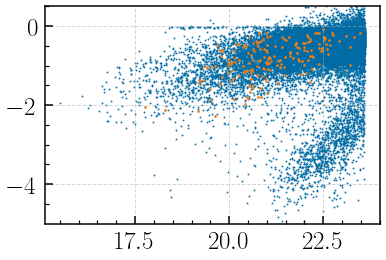

In [119]:
_ = plt.scatter(
    pdr2_cos_bsm['r_cmodel_mag'],
    pdr2_cos_bsm['r_cmodel_mag'] - (-2.5 * np.log10(pdr2_cos_bsm['r_undeblended_convolvedflux_2_15_flux']) + 31.4),
    s=1, alpha=0.8
)

_ = plt.scatter(
    pdr2_match_bsm['r_cmodel_mag'],
    pdr2_match_bsm['r_cmodel_mag'] - (-2.5 * np.log10(pdr2_match_bsm['r_undeblended_convolvedflux_2_15_flux']) + 31.4),
    s=3, alpha=0.8
)

plt.ylim(-5, 0.5)

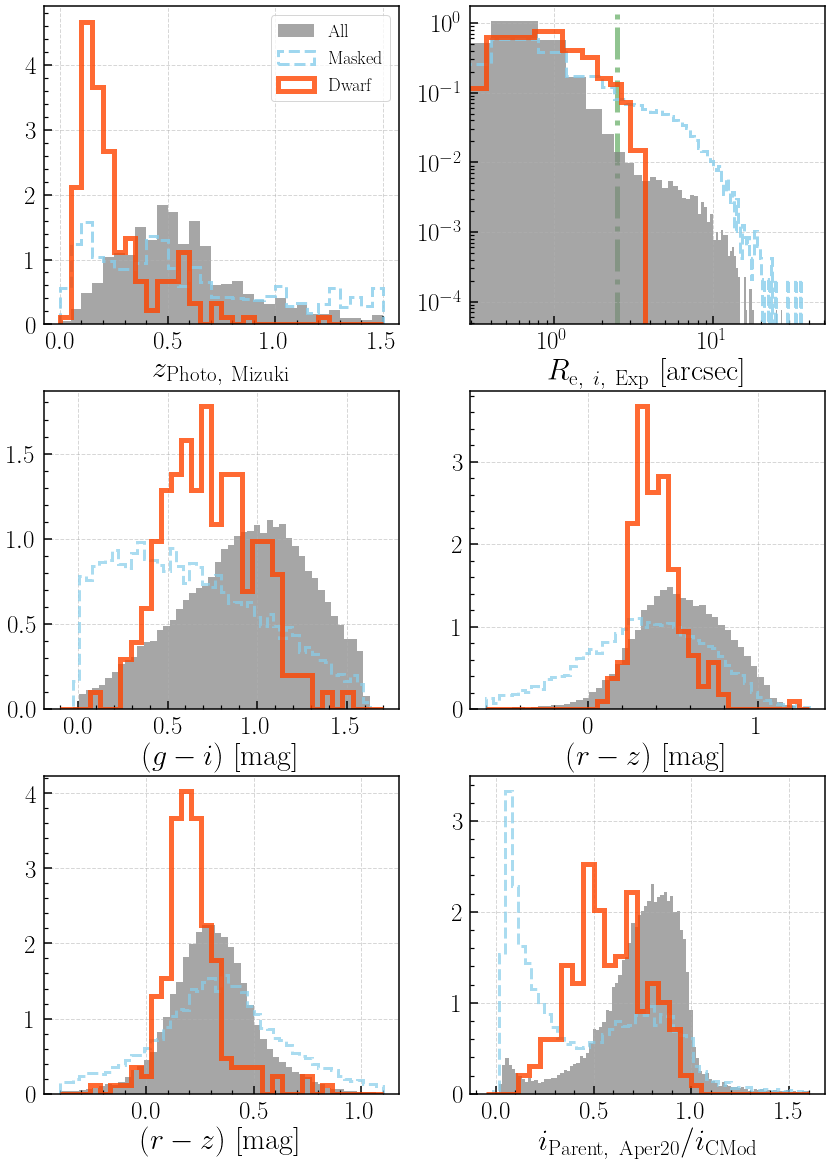

In [91]:
fig, axs = plt.subplots(3, 2, figsize=(14, 20))
plt.subplots_adjust(hspace=0.21)


# Photo-z
ax1 = axs[0, 0]
_ = ax1.hist(pdr2_cos_bsm['photoz_best'], range=(0, 1.5), bins=30, histtype='stepfilled', 
             color='grey', linewidth=1, alpha=0.7, label=r'$\rm All$', density=True)

_ = ax1.hist(pdr2_cos_msk['photoz_best'], range=(0, 1.5), bins=30, histtype='step', 
             color='skyblue', linewidth=3, linestyle='--', alpha=0.8, label=r'$\rm Masked$', density=True)

_ = ax1.hist(pdr2_match_bsm['photoz_best'], range=(0, 1.5), bins=30, histtype='step', 
             color='orangered', linewidth=5, linestyle='-', alpha=0.8, label=r'$\rm Dwarf$', density=True)


ax1.legend(fontsize=18)

_ = ax1.set_xlabel(r'$z_{\rm Photo,\ Mizuki}$', fontsize=30)

# CModel, exponential size

ax2 = axs[0, 1]
ax2.loglog()

_ = ax2.hist(pdr2_cos_bsm['i_cmodel_exp_ellipse_r'], range=(0, 40), bins=100, histtype='stepfilled', 
             color='grey', linewidth=1, alpha=0.7, label=r'$\rm All$', density=True)

_ = ax2.hist(pdr2_cos_msk['i_cmodel_exp_ellipse_r'], range=(0, 40), bins=100, histtype='step', 
             color='skyblue', linewidth=3, linestyle='--', alpha=0.8, label=r'$\rm All$', density=True)

_ = ax2.hist(pdr2_match_bsm['i_cmodel_exp_ellipse_r'], range=(0, 15), bins=40, histtype='step', 
             color='orangered', linewidth=5, linestyle='-', alpha=0.8, label=r'$\rm Dwarf$', density=True)

_ = ax2.set_xlabel(r'$R_{{\rm e},\ i,\ \rm Exp}\ [\rm arcsec]$', fontsize=30)
_ = ax2.axvline(2.5, linestyle='-.', c='forestgreen', linewidth=5, alpha=0.5, zorder=0)


# CModel (g-i) color
ax3 = axs[1, 0]

_ = ax3.hist(pdr2_cos_bsm['g_cmodel_mag'] - pdr2_cos_bsm['i_cmodel_mag'], 
             range=(-0.1, 1.7), bins=50, histtype='stepfilled', 
             color='grey', linewidth=1, alpha=0.7, label=r'$\rm All$', density=True)

_ = ax3.hist(pdr2_cos_msk['g_cmodel_mag'] - pdr2_cos_msk['i_cmodel_mag'], 
             range=(-0.1, 1.7), bins=50, histtype='step', 
             color='skyblue', linewidth=3, linestyle='--', alpha=0.7, label=r'$\rm All$', density=True)

_ = ax3.hist(pdr2_match_bsm['g_cmodel_mag'] - pdr2_match_bsm['i_cmodel_mag'], 
             range=(-0.1, 1.7), bins=32, histtype='step', 
             color='orangered', linewidth=5, linestyle='-', alpha=0.8, label=r'$\rm Dwarf$', density=True)

_ = ax3.set_xlabel(r'$(g-i)\ [\rm mag]$', fontsize=30)

# CModel (r-z) color
ax4 = axs[1, 1]

_ = ax4.hist(pdr2_cos_bsm['r_cmodel_mag'] - pdr2_cos_bsm['z_cmodel_mag'], 
             range=(-0.6, 1.3), bins=50, histtype='stepfilled', 
             color='grey', linewidth=1, alpha=0.7, label=r'$\rm All$', density=True)

_ = ax4.hist(pdr2_cos_msk['r_cmodel_mag'] - pdr2_cos_msk['z_cmodel_mag'], 
             range=(-0.6, 1.3), bins=50, histtype='step', 
             color='skyblue', linewidth=3, linestyle='--', alpha=0.7, label=r'$\rm All$', density=True)

_ = ax4.hist(pdr2_match_bsm['r_cmodel_mag'] - pdr2_match_bsm['z_cmodel_mag'], 
             range=(-0.6, 1.3), bins=32, histtype='step', 
             color='orangered', linewidth=5, linestyle='-', alpha=0.8, label=r'$\rm Dwarf$', density=True)

_ = ax4.set_xlabel(r'$(r-z)\ [\rm mag]$', fontsize=30)

# CModel (i-y) color
ax5 = axs[2, 0]

_ = ax5.hist(pdr2_cos_bsm['i_cmodel_mag'] - pdr2_cos_bsm['y_cmodel_mag'], 
             range=(-0.4, 1.1), bins=50, histtype='stepfilled', 
             color='grey', linewidth=1, alpha=0.7, label=r'$\rm All$', density=True)

_ = ax5.hist(pdr2_cos_msk['i_cmodel_mag'] - pdr2_cos_msk['y_cmodel_mag'], 
             range=(-0.4, 1.1), bins=50, histtype='step', 
             color='skyblue', linewidth=3, linestyle='--', alpha=0.7, label=r'$\rm All$', density=True)

_ = ax5.hist(pdr2_match_bsm['i_cmodel_mag'] - pdr2_match_bsm['y_cmodel_mag'], 
             range=(-0.4, 1.1), bins=32, histtype='step', 
             color='orangered', linewidth=5, linestyle='-', alpha=0.8, label=r'$\rm Dwarf$', density=True)

_ = ax5.set_xlabel(r'$(r-z)\ [\rm mag]$', fontsize=30)


# Ratio between aperture and CModel flux
ax6 = axs[2, 1]
#ax6.loglog()

_ = ax6.hist(pdr2_cos_bsm['i_undeblended_convolvedflux_3_20_flux'] / pdr2_cos_bsm['i_cmodel_flux'], 
             range=(-0.05, 1.6), bins=100, histtype='stepfilled', 
             color='grey', linewidth=1, alpha=0.7, label=r'$\rm All$', density=True)

_ = ax6.hist(pdr2_cos_msk['i_undeblended_convolvedflux_3_20_flux'] / pdr2_cos_msk['i_cmodel_flux'],
             range=(-0.05, 1.6), bins=50, histtype='step', 
             color='skyblue', linewidth=3, linestyle='--', alpha=0.7, label=r'$\rm All$', density=True)

_ = ax6.hist(pdr2_match_bsm['i_undeblended_convolvedflux_3_20_flux'] / pdr2_match_bsm['i_cmodel_flux'],
             range=(-0.05, 1.6), bins=30, histtype='step', 
             color='orangered', linewidth=5, linestyle='-', alpha=0.8, label=r'$\rm Dwarf$', density=True)

_ = ax6.set_xlabel(r'$i_{\rm Parent,\ Aper20}/i_{\rm CMod}$', fontsize=30)

In [69]:
pdr2_cos_bsm.colnames

['object_id',
 'ra',
 'dec',
 'tract',
 'patch',
 'a_g',
 'a_r',
 'a_i',
 'a_z',
 'a_y',
 'g_cmodel_exp_flux',
 'g_cmodel_exp_fluxsigma',
 'r_cmodel_exp_flux',
 'r_cmodel_exp_fluxsigma',
 'i_cmodel_exp_flux',
 'i_cmodel_exp_fluxsigma',
 'z_cmodel_exp_flux',
 'z_cmodel_exp_fluxsigma',
 'y_cmodel_exp_flux',
 'y_cmodel_exp_fluxsigma',
 'g_cmodel_flux',
 'g_cmodel_fluxsigma',
 'r_cmodel_flux',
 'r_cmodel_fluxsigma',
 'i_cmodel_flux',
 'i_cmodel_fluxsigma',
 'z_cmodel_flux',
 'z_cmodel_fluxsigma',
 'y_cmodel_flux',
 'y_cmodel_fluxsigma',
 'g_cmodel_mag',
 'g_cmodel_magsigma',
 'r_cmodel_mag',
 'r_cmodel_magsigma',
 'i_cmodel_mag',
 'i_cmodel_magsigma',
 'z_cmodel_mag',
 'z_cmodel_magsigma',
 'y_cmodel_mag',
 'y_cmodel_magsigma',
 'g_cmodel_flag',
 'r_cmodel_flag',
 'i_cmodel_flag',
 'z_cmodel_flag',
 'y_cmodel_flag',
 'g_psf_flux',
 'g_psf_fluxsigma',
 'r_psf_flux',
 'r_psf_fluxsigma',
 'i_psf_flux',
 'i_psf_fluxsigma',
 'z_psf_flux',
 'z_psf_fluxsigma',
 'y_psf_flux',
 'y_psf_fluxsigma',
 

### Generate color cuouts for the "true" COSMOS dwarfs after the bright star mask

In [107]:
from unagi import hsc
from unagi import task
from unagi import query
from unagi import config
from unagi import catalog
from unagi import plotting

s20a_w = hsc.Hsc(dr='dr3', rerun='s20a_wide')

# Get table list from /Users/song/Dropbox/work/project/unagi/unagi/data/s20a_wide/s20a_wide_tables.fits
# Get table list from /Users/song/Dropbox/work/project/unagi/unagi/data/s20a_dud/s20a_dud_tables.fits


In [ ]:
pdr2_match_bsm.add_column(Column(data=np.arange(len(pdr2_match_bsm)) + 1, name='index'))

for obj in pdr2_match_bsm:
    
    coord = SkyCoord(obj['ra'], obj['dec'], frame='icrs', unit='deg')
    
    # Use angular size and don't save the data
    cutout_rgb, cutout_wcs = task.hsc_tricolor(
        coord, cutout_size=(10.0 * u.arcsec), filters='gri', verbose=False, 
        save_rgb=False, save_img=False, use_saved=False, archive=s20a_d)

    fig_1 = plt.figure(figsize=(8, 8))
    ax1 = fig_1.add_subplot(111)
    ax1.grid(False)
    ax1 = plotting.display_single(
        cutout_rgb, ax=ax1, contrast=0.1, scale_bar_length=5, scale_bar_color='w')
    
    fig_1.savefig(
        '/Users/song/Downloads/merian/cosmos/truth/cosmos_dwarf_{:d}_gri.png'.format(obj['index']))
    plt.close(fig_1)
    
    #cutout_objs = task.hsc_box_search(
    #    coord, box_size=(10.0 * u.arcsec), redshift=None, archive=s20a_w,
    #    verbose=False, psf=True, cmodel=True, aper=False, shape=True,
    #    meas='i', flux=False, aper_type='3_20')
    
    #fig_2 = plotting.cutout_show_objects(
    #    cutout_rgb, cutout_objs, show_clean=False, xsize=10, band='i', scale_bar_color='w',
    #    show_mag=False, show_weighted=True, cutout_wcs=cutout_wcs, scale_bar_length=5,
    #    verbose=False)
    
    #fig_2.savefig(
    #    '/Users/song/Downloads/merian/cosmos/cosmos_dwarf_{:d}_cmodel.png'.format(obj['index']))
    #plt.close(fig_2)